In [1]:
import sys
import os

from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown

DOWNLOAD = False

if DOWNLOAD:
    url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
    output = "IT_data.h5"
    gdown.download(url, output, quiet=False, fuzzy=True)


## 0. Load data

In [2]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape


 Preprocessing: scaling, flattening images into pixals and keeping 1000 PCs (if needed). Transfer labels into numbers.

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_selection import r_regression
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_validate,KFold

X_train = stimulus_train.reshape(stimulus_train.shape[0], -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val = stimulus_val.reshape(stimulus_val.shape[0], -1)
X_val_scaled = scaler.fit_transform(X_val)
X_test = stimulus_test.reshape(stimulus_test.shape[0], -1)
X_test_scaled = scaler.fit_transform(X_test)

In [4]:
pca = PCA(n_components=1000)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

X_train_pca.shape,X_val_pca.shape,X_test_pca.shape

((2592, 1000), (288, 1000), (320, 1000))

In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
objects_train_encoded = label_encoder.fit_transform(objects_train)

## 1. Linear regression with PCA

In [6]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_pca, spikes_train)
predictions_train_lr = model.predict(X_train_pca)
predictions_val_lr = model.predict(X_val_pca)

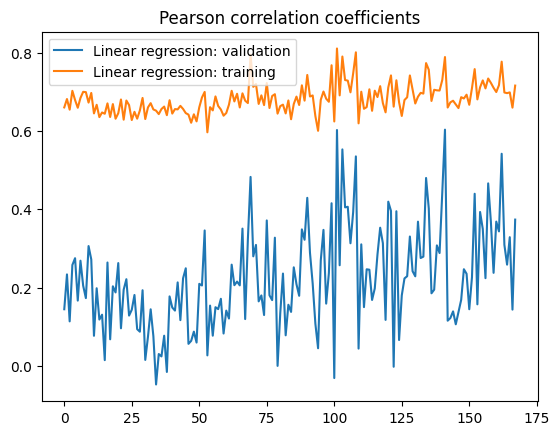

Pearson correlation on training set: 0.6819707279233436
Pearson correlation on validation set: 0.22149203024950356


<Figure size 640x480 with 0 Axes>

In [7]:
pearson_corr_lr = np.zeros((n_neurons,2))
for i in range(n_neurons):
    pearson_corr_lr[i,0] = np.corrcoef(predictions_val_lr[:, i], spikes_val[:, i])[0, 1]
    pearson_corr_lr[i,1] = np.corrcoef(predictions_train_lr[:, i], spikes_train[:, i])[0, 1]
plt.figure()
plt.title('Pearson correlation coefficients')
plt.plot(pearson_corr_lr[:,0], label='Linear regression: validation')
plt.plot(pearson_corr_lr[:,1], label='Linear regression: training')
plt.legend()
plt.show()
plt.figure()

print(f"Pearson correlation on training set: {np.mean(pearson_corr_lr[:,1])}")
print(f"Pearson correlation on validation set: {np.mean(pearson_corr_lr[:,0])}")

## 2. Ridge regression

In [8]:
from sklearn.metrics import make_scorer
#from scipy.stats import pearsonr
# Define a scoring function compatible with make_scorer
def pearson_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        r = np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1]
        if np.isnan(r):
            r = 0
        if np.isinf(r):
            r = 0
        scores.append(r)
    return np.mean(scores)

# Wrap it as a scorer (greater_is_better=True is default)
pearson_scorer = make_scorer(pearson_score, greater_is_better=True)

In [9]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, GroupKFold

# Ridge model
ridge = Ridge(max_iter=10000, tol=1e-6)

# Grid of alpha values
param_grid = {'alpha': np.logspace(-4, 4, 10)}

# GroupKFold ensures the same label distribution in each fold
cv = GroupKFold(n_splits=10)

# Wrap with GridSearchCV, pass groups
grid = GridSearchCV(ridge, param_grid, cv=cv, scoring=pearson_scorer, n_jobs=-1)

# Fit with groups controlling label distribution
grid.fit(X_train_pca, spikes_train, groups=objects_train_encoded)

# Results
print("Best alpha:", grid.best_params_['alpha'])
print("Best pearson correlation:", grid.best_score_)

Best alpha: 10000.0
Best pearson correlation: 0.15515056888298542


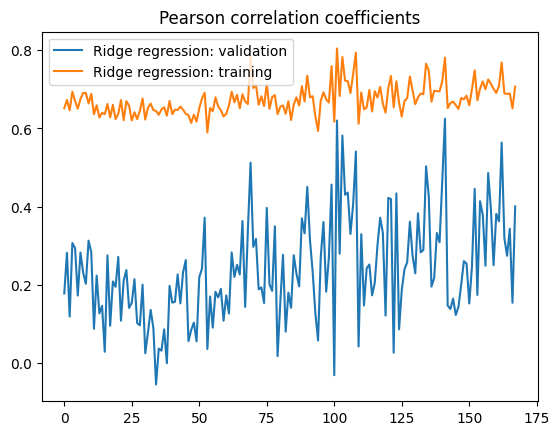

Pearson correlation on training set: 0.6738006717588618
Pearson correlation on validation set: 0.2386047001508949


<Figure size 640x480 with 0 Axes>

In [10]:
grid.best_estimator_.fit(X_train_pca, spikes_train)
predictions_train_ridge = grid.best_estimator_.predict(X_train_pca)
predictions_val_ridge = grid.best_estimator_.predict(X_val_pca)

pearson_corr_ridge = np.zeros((n_neurons,2))
for i in range(n_neurons):
    pearson_corr_ridge[i,0] = np.corrcoef(predictions_train_ridge[:, i], spikes_train[:, i])[0, 1]
    pearson_corr_ridge[i,1] = np.corrcoef(predictions_val_ridge[:, i], spikes_val[:, i])[0, 1]
plt.figure()
plt.title('Pearson correlation coefficients')
plt.plot(pearson_corr_ridge[:,1], label='Ridge regression: validation')
plt.plot(pearson_corr_ridge[:,0], label='Ridge regression: training')
plt.legend()
plt.show()
plt.figure()

print(f"Pearson correlation on training set: {np.mean(pearson_corr_ridge[:,0])}")
print(f"Pearson correlation on validation set: {np.mean(pearson_corr_ridge[:,1])}")

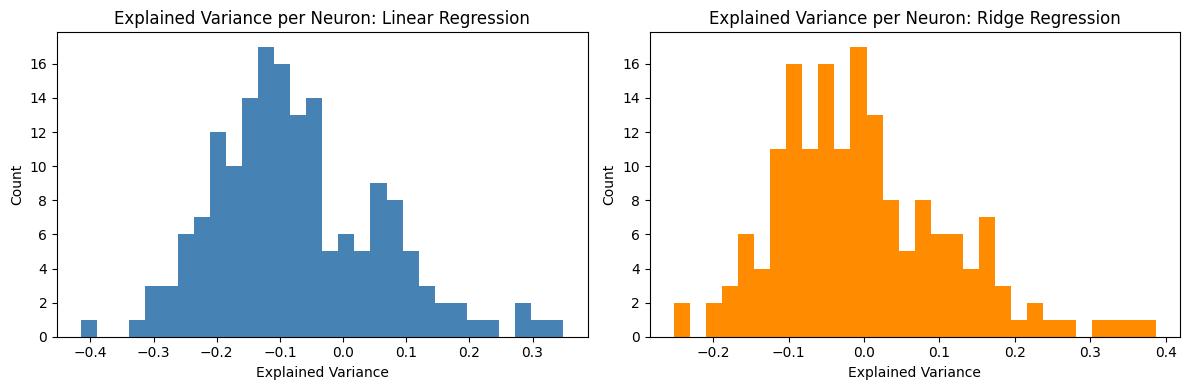

In [11]:
# explained variance on validation set
from sklearn.metrics import explained_variance_score

explained_var_lr = explained_variance_score(spikes_val, predictions_val_lr, multioutput='raw_values')
explained_var_ridge = explained_variance_score(spikes_val, predictions_val_ridge, multioutput='raw_values')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(explained_var_lr, bins=30, color='steelblue')
plt.title("Explained Variance per Neuron: Linear Regression")
plt.xlabel("Explained Variance")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(explained_var_ridge, bins=30, color='darkorange')
plt.title("Explained Variance per Neuron: Ridge Regression")
plt.xlabel("Explained Variance")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

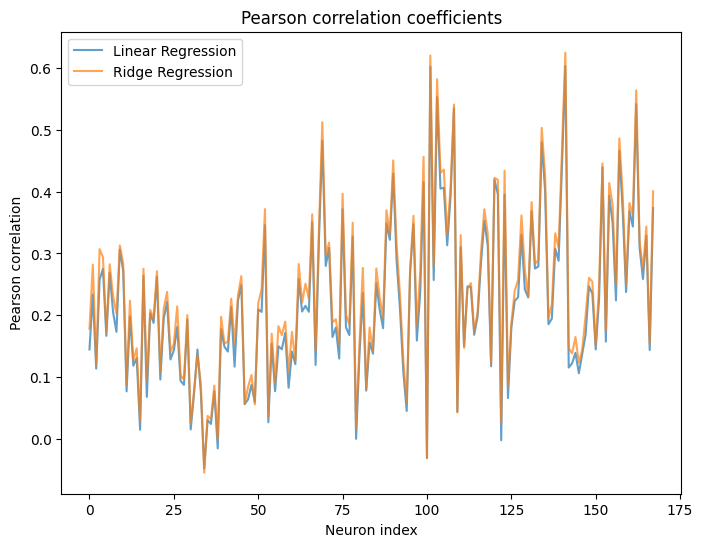

In [13]:
plt.figure(figsize=(8,6))
plt.plot(pearson_corr_lr[:,0], label='Linear Regression', alpha=0.7)
plt.plot(pearson_corr_ridge[:,1], label='Ridge Regression', alpha=0.7)
plt.xlabel('Neuron index')
plt.ylabel('Pearson correlation')
plt.title('Pearson correlation coefficients')
plt.legend()
plt.show()

## 3. Prediction

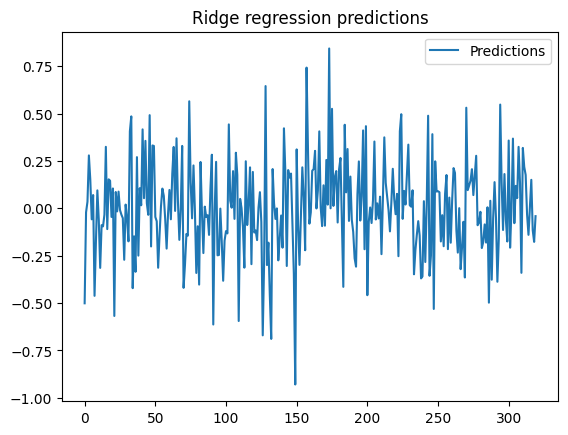

In [12]:
spikes_test_pred = grid.best_estimator_.predict(X_test_pca)

neuron_idx = 5
plt.figure()
plt.title('Ridge regression predictions')
plt.plot(spikes_test_pred[:, neuron_idx], label='Predictions')
plt.legend()
plt.show()